## Edge Detection
Detect Signals in OAAM Functions Layer. Outputs polylines describing the connections. 

Conceptionally similar to scalable vertex detection. 

Tailored on the functions editor. Should be generalizable with medium effort. Expects vertical or horizontal line segments. Does not yet support crossings or other crossing solutions. Not tested for lines close to each other. Does not support diagonal lines, currently not a thing. Would be interesting with probabilistic Hough Trafo, but would probably need to subtract all other matches from the result. 

Maybe switch to template matching (with kind of same kernel/template). 

In [24]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import plotly.graph_objects as go
import random as random

### Input

In [25]:
target_image_path = 'images/testcase6.png'

target_img = cv2.imread(target_image_path)

# Convert to grayscale
target_gray = cv2.cvtColor(target_img, cv2.COLOR_BGR2GRAY)

activate_plotly = True

### Visualization of Input
Grayscale is enough here. Kernel methods are not really for multi channel images.

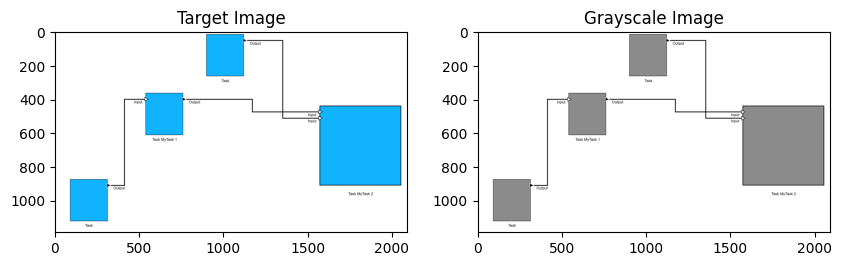

In [26]:
# Draw target image and grayscale image side by side
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Draw target image
ax[0].imshow(cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB))
ax[0].set_title('Target Image')

# Draw grayscale image
ax[1].imshow(target_gray, cmap='gray')
ax[1].set_title('Grayscale Image')

plt.show()

## Kernel / Custom Filter
Kernel Custom Line Detection and generation of intersection template image for later use

idea for later: search for many thicknesses of lines

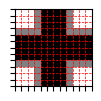

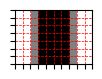

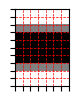

In [27]:
# Kernel / Custom Filter
# Define one vertical kernel, one horizontal kernel, and cross_kernel0

# Define custom kernels
kernel_vertical = np.tile(np.array([[1, 1, 0, -1, -1, -1, -1, 0, 1, 1]], dtype=np.float32), (7, 1))
kernel_horizontal = np.transpose(kernel_vertical)

# Define cross kernel
kernel_cross_0 = np.ones((12, 12))
kernel_cross_0[3:9, 0:12] = 0.5  # Left vertical outline
kernel_cross_0[0:12, 3:9] = 0.5  # Right vertical outline
kernel_cross_0[4:8, 0:12] = 0  # Vertical part of the cross
kernel_cross_0[0:12, 4:8] = 0  # Horizontal part of the cross

# Visualize the cross kernel with grid overlay
plt.figure(figsize=(1, 1))
plt.imshow(kernel_cross_0, cmap='gray')
plt.grid(True, which='both', color='red', linestyle='--', linewidth=0.5)
plt.xticks(np.arange(-.5, kernel_cross_0.shape[1], 1), [])
plt.yticks(np.arange(-.5, kernel_cross_0.shape[0], 1), [])
plt.show()

# Visualize the vertical kernel with grid overlay
plt.figure(figsize=(1, 1))
plt.imshow(kernel_vertical, cmap='gray')
plt.grid(True, which='both', color='red', linestyle='--', linewidth=0.5)
plt.xticks(np.arange(-.5, kernel_vertical.shape[1], 1), [])
plt.yticks(np.arange(-.5, kernel_vertical.shape[0], 1), [])
plt.show()

# Visualize the horizontal kernel with grid overlay
plt.figure(figsize=(1, 1))
plt.imshow(kernel_horizontal, cmap='gray')
plt.grid(True, which='both', color='red', linestyle='--', linewidth=0.5)
plt.xticks(np.arange(-.5, kernel_horizontal.shape[1], 1), [])
plt.yticks(np.arange(-.5, kernel_horizontal.shape[0], 1), [])
plt.show()


#### Applying custom filter to find vertical and horizontal edges
tried to find intersections this way as well, but it did not work

visualization of output at the end

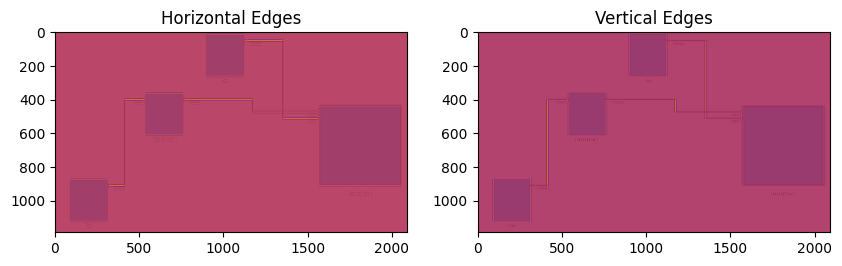

In [28]:
target_gray_temp = target_gray.copy()

# Apply vertical kernel
result_filter_ver = cv2.filter2D(target_gray_temp, cv2.CV_32F, kernel_vertical)

# Apply horizontal kernel
result_filter_hor = cv2.filter2D(target_gray_temp, cv2.CV_32F, kernel_horizontal)

# Combine the individual results into single arrays
combined_hor = result_filter_hor
combined_ver = result_filter_ver

# Overlay both heatmaps on the target image
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB))
ax[0].imshow(combined_hor, cmap='inferno', alpha=0.9)
ax[0].set_title('Horizontal Edges')
ax[1].imshow(cv2.cvtColor(target_img, cv2.COLOR_BGR2RGB))
ax[1].imshow(combined_ver, cmap='inferno', alpha=0.9)
ax[1].set_title('Vertical Edges')
plt.show()


#### Normalizing to 8 Bit

In [29]:
# Normalize to 0-255 and convert to uint8
result_filter_ver_norm = cv2.normalize(result_filter_ver, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
result_filter_hor_norm = cv2.normalize(result_filter_hor, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)

#### Thresholding and visualization

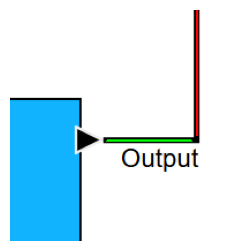

In [30]:
threshold = 230
_, result_filter_ver_thresh = cv2.threshold(result_filter_ver_norm, threshold, 255, cv2.THRESH_BINARY)
_, result_filter_hor_thresh = cv2.threshold(result_filter_hor_norm, threshold, 255, cv2.THRESH_BINARY)

hv_edges_thresh = result_filter_ver_thresh + result_filter_hor_thresh

# Save hv_edges_thresh as a .png image
cv2.imwrite('hv_edges_thresh.png', hv_edges_thresh)

# Zoom in on the specified area (350, 900) on the horizontal and vertical threshold images and the original image
zoom_center = (350, 900)
zoom_size = 200

# Define the zoomed area
x_start = max(zoom_center[0] - zoom_size // 2, 0)
x_end = min(zoom_center[0] + zoom_size // 2, result_filter_hor_thresh.shape[1])
y_start = max(zoom_center[1] - zoom_size // 2, 0)
y_end = min(zoom_center[1] + zoom_size // 2, result_filter_hor_thresh.shape[0])

# Extract the zoomed area from horizontal and vertical threshold images and the original image
zoomed_hor_thresh = result_filter_hor_thresh[y_start:y_end, x_start:x_end]
zoomed_ver_thresh = result_filter_ver_thresh[y_start:y_end, x_start:x_end]
zoomed_original = target_img[y_start:y_end, x_start:x_end]

# Convert the zoomed threshold images to RGBA
zoomed_hor_thresh_rgba = cv2.cvtColor(zoomed_hor_thresh, cv2.COLOR_GRAY2RGBA)
zoomed_ver_thresh_rgba = cv2.cvtColor(zoomed_ver_thresh, cv2.COLOR_GRAY2RGBA)
zoomed_hor_thresh_rgba[:, :, 3] = 255  # Set alpha channel to 255
zoomed_ver_thresh_rgba[:, :, 3] = 255  # Set alpha channel to 255

# Overlay the zoomed threshold images on the zoomed original image
overlay = zoomed_original.copy()
overlay[zoomed_hor_thresh != 0] = [0, 255, 0]  # Set non-black pixels to green for horizontal edges
overlay[zoomed_ver_thresh != 0] = [0, 0, 255]  # Set non-black pixels to red for vertical edges

# Display the overlay image
plt.figure(figsize=(3, 3))
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

### From Pixels to Contours
Group Pixels to Contours and draw them onto the target image

Found 7 horizontal contours, and 4 vertical contours


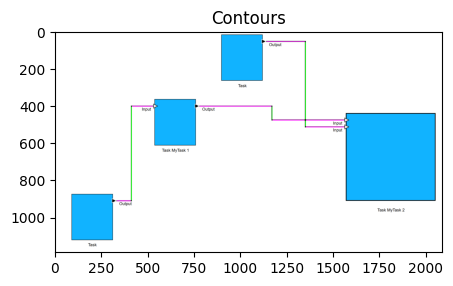

In [31]:
# Find contours
contours_hor, _ = cv2.findContours(result_filter_hor_thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours_ver, _ = cv2.findContours(result_filter_ver_thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(f'Found {len(contours_hor)} horizontal contours, and {len(contours_ver)} vertical contours')

# Draw the contours. Horizontal in blue, vertical in green
contour_img_all = target_img.copy()
# Convert contours to the correct format
contours_hor = [np.array(contour, dtype=np.int32) for contour in contours_hor]
contours_ver = [np.array(contour, dtype=np.int32) for contour in contours_ver]

# Draw contours
cv2.drawContours(contour_img_all, contours_hor, -1, (255, 0, 255), 2)
cv2.drawContours(contour_img_all, contours_ver, -1, (0, 255, 0), 2)

# Plot the contours
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(cv2.cvtColor(contour_img_all, cv2.COLOR_BGR2RGB))
ax.set_title('Contours')
plt.show()

#### Filter out very short Contours
thes are mainly false positives, for example at the ports or the characters.
They are very hard to see.

In [32]:
# Filter out very short contours
min_contour_length = 20
contours_hor_filtered = [c for c in contours_hor if cv2.arcLength(c, False) > min_contour_length]
contours_ver_filtered = [c for c in contours_ver if cv2.arcLength(c, False) > min_contour_length]
print(f'After filtering, found {len(contours_hor_filtered)} horizontal contours, and {len(contours_ver_filtered)} vertical contours.')
print(f'Filtered out {len(contours_hor) - len(contours_hor_filtered)} horizontal contours, and {len(contours_ver) - len(contours_ver_filtered)} vertical contours.')

After filtering, found 7 horizontal contours, and 4 vertical contours.
Filtered out 0 horizontal contours, and 0 vertical contours.


#### From Contours to Line Segments
Contours are areas (but very line segment looking). So they are approximated to line segments.

In [33]:
def vertical_contours_to_vertical_segments(contours):
    lines = []
    for contour in contours:
        # Simplify contour to ensure it's processed as a line if it's not already
        simplified_contour = cv2.approxPolyDP(contour, epsilon=0.5, closed=False)

        # Extract the vertical extents by finding min and max y coordinates
        x_coords = simplified_contour[:, :, 0]
        y_coords = simplified_contour[:, :, 1]
        
        y1, y2 = np.min(y_coords), np.max(y_coords)
        x = np.mean(x_coords).astype(int)  # Assuming vertical, x should be constant
        
        lines.append(((x, y1), (x, y2)))
    
    return lines

def horizontal_contours_to_horizontal_segments(contours):
    lines = []
    for contour in contours:
        # Simplify contour to ensure it's processed as a line if it's not already
        simplified_contour = cv2.approxPolyDP(contour, epsilon=0.5, closed=False)

        # Extract the horizontal extents by finding min and max x coordinates
        x_coords = simplified_contour[:, :, 0]
        y_coords = simplified_contour[:, :, 1]
        
        x1, x2 = np.min(x_coords), np.max(x_coords)
        y = np.mean(y_coords).astype(int)  # Assuming horizontal, y should be constant
        
        lines.append(((x1, y), (x2, y)))
    
    return lines

line_segments_ver = vertical_contours_to_vertical_segments(contours_ver_filtered)
line_segments_hor = horizontal_contours_to_horizontal_segments(contours_hor_filtered)

#### Visualize the Line Segments and highlight the points

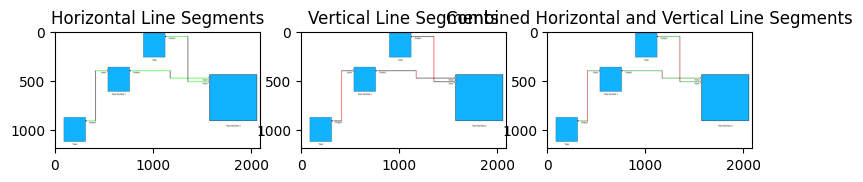

Vertical line segments:
0: Start: (1349, 483), End: (1349, 511); 1: Start: (1169, 407), End: (1169, 474); 2: Start: (411, 407), End: (411, 908); 3: Start: (1349, 60), End: (1349, 472); 

Horizontal line segments:
0: Start: (333, 912), End: (407, 912); 1: Start: (1353, 515), End: (1557, 515); 2: Start: (1354, 478), End: (1557, 478); 3: Start: (1173, 478), End: (1343, 478); 4: Start: (780, 403), End: (1165, 403); 5: Start: (416, 403), End: (526, 403); 6: Start: (1140, 56), End: (1345, 56); 


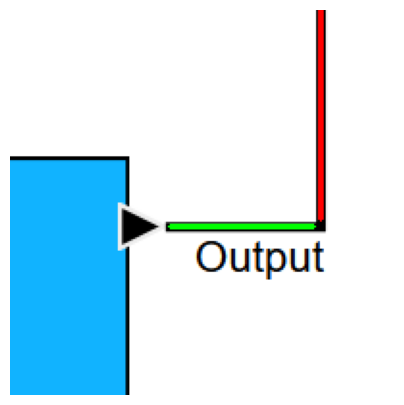

In [34]:
# Draw the horizontal lines
edges_hor_img = target_img.copy()
for line in line_segments_hor:
    cv2.line(edges_hor_img, line[0], line[1], (0, 255, 0), 4)

# Draw the vertical lines
edges_ver_img = target_img.copy()
for line in line_segments_ver:
    cv2.line(edges_ver_img, line[0], line[1], (0, 0, 255), 4)

# Draw the combined lines
edges_combined_img = target_img.copy()
for line in line_segments_hor:
    cv2.line(edges_combined_img, line[0], line[1], (0, 255, 0), 2)
    #cv2.circle(edges_combined_img, line[0], 5, (0, 255, 0), -1)
    #cv2.circle(edges_combined_img, line[1], 5, (0, 255, 0), -1)
for line in line_segments_ver:
    cv2.line(edges_combined_img, line[0], line[1], (0, 0, 255), 2)
    #cv2.circle(edges_combined_img, line[0], 5, (0, 0, 255), -1)
    #cv2.circle(edges_combined_img, line[1], 5, (0, 0, 255), -1)

# Create a single figure with three subplots (1 row, 3 columns)
fig, ax = plt.subplots(1, 3, figsize=(9, 3))

# Plot the horizontal lines in the first subplot
ax[0].imshow(cv2.cvtColor(edges_hor_img, cv2.COLOR_BGR2RGB))
ax[0].set_title('Horizontal Line Segments')

# Plot the vertical lines in the second subplot
ax[1].imshow(cv2.cvtColor(edges_ver_img, cv2.COLOR_BGR2RGB))
ax[1].set_title('Vertical Line Segments')

# Plot the combined lines in the third subplot
ax[2].imshow(cv2.cvtColor(edges_combined_img, cv2.COLOR_BGR2RGB))
ax[2].set_title('Combined Horizontal and Vertical Line Segments')

plt.show()

# Print all vertical line segments
print("Vertical line segments:")
for i, ver_line in enumerate(line_segments_ver):
    print(f"{i}: Start: ({ver_line[0][0]}, {ver_line[0][1]}), End: ({ver_line[1][0]}, {ver_line[1][1]})", end='; ')
print("\n")

# Print all horizontal line segments
print("Horizontal line segments:")
for i, hor_line in enumerate(line_segments_hor):
    print(f"{i}: Start: ({hor_line[0][0]}, {hor_line[0][1]}), End: ({hor_line[1][0]}, {hor_line[1][1]})", end='; ')
print()



# Zoom in on the specified area (350, 900) on the combined horizontal and vertical line segments image
zoom_center = (350, 900)
zoom_size = 200

# Define the zoomed area
x_start = max(zoom_center[0] - zoom_size // 2, 0)
x_end = min(zoom_center[0] + zoom_size // 2, edges_combined_img.shape[1])
y_start = max(zoom_center[1] - zoom_size // 2, 0)
y_end = min(zoom_center[1] + zoom_size // 2, edges_combined_img.shape[0])

# Extract the zoomed area from the combined horizontal and vertical line segments image
zoomed_combined = edges_combined_img[y_start:y_end, x_start:x_end]

# Display the zoomed combined image
plt.figure(figsize=(5, 5))
plt.imshow(cv2.cvtColor(zoomed_combined, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

#### sort the line segments - not needed any more

In [35]:
# Sort horizontal segments from left to right and vertical segments from top to bottom
# Separated vertical and horizontal segments
line_segments_hor_sorted = line_segments_hor.copy()
# line_segments_hor_sorted.sort(key=lambda seg: (seg[0][0], seg[0][1]))
line_segments_ver_sorted = line_segments_ver.copy()
# line_segments_ver_sorted.sort(key=lambda seg: (seg[0][1], seg[0][0]))

#### finding and handeling signal boxes
assuming signals always go straight through a signal box. finding them using template matching and connecting the lines simmilarly to intersection detection algorythm. then the rest of the program can work normally

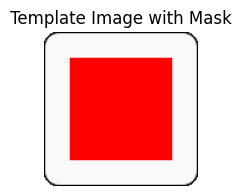

In [36]:
containers_on_target_img = target_img.copy()
container = cv2.imread('images/container.png')
container = cv2.resize(container, (150, 150), interpolation=cv2.INTER_AREA)
# Create a mask for the container
mask = np.ones(container.shape[:2], dtype=np.uint8) * 255
mask[25:125, 25:125] = 0  # Define the square area to be ignored

# Apply the mask to the template matching
res = cv2.matchTemplate(containers_on_target_img, container, cv2.TM_CCOEFF_NORMED, mask=mask)

# res = cv2.matchTemplate(containers_on_target_img, container, cv2.TM_CCOEFF_NORMED) # TM_CCOEFF_NORMED seems to work best

# Threshold the result
threshold = 0.8 # false positives below 0.65
loc = np.where(res >= threshold)

containers = []
for pt in zip(*loc[::-1]):
    center_x = pt[0] + container.shape[1] // 2
    center_y = pt[1] + container.shape[0] // 2
    containers.append((center_x, center_y))

# Print the container centers
for center in containers:
    print(f"Container center: ({center[0]}, {center[1]})")

# Visualize the mask on the template image
container_with_mask = container.copy()
container_with_mask[mask == 0] = [0, 0, 255]  # Highlight the masked area in red

plt.figure(figsize=(2, 2))
plt.imshow(cv2.cvtColor(container_with_mask, cv2.COLOR_BGR2RGB))
plt.title('Template Image with Mask')
plt.axis('off')
plt.show()

#### removing matches with other matches in close proximity

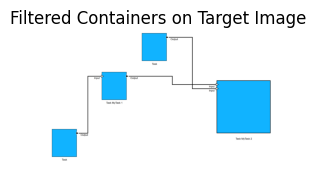

In [37]:
def remove_close_containers(containers, proximity=5):
    # Sort containers by x and then by y to ensure upper left ones come first
    containers = sorted(containers, key=lambda pt: (pt[0], pt[1]))
    
    filtered_containers = []
    while containers:
        current = containers.pop(0)
        filtered_containers.append(current)
        
        # Remove containers that are within the proximity range
        containers = [pt for pt in containers if abs(pt[0] - current[0]) > proximity or abs(pt[1] - current[1]) > proximity]
    
    return filtered_containers

# Remove close containers
filtered_containers = remove_close_containers(containers, proximity=5)
containers = filtered_containers

# Print the filtered containers
for center in filtered_containers:
    print(f"Filtered Container center: ({center[0]}, {center[1]})")

# Visualize the filtered containers on the target image
filtered_containers_img = target_img.copy()
for center in filtered_containers:
    cv2.circle(filtered_containers_img, center, 10, (0, 0, 255), -1)

plt.figure(figsize=(3, 3))
plt.imshow(cv2.cvtColor(filtered_containers_img, cv2.COLOR_BGR2RGB))
plt.title('Filtered Containers on Target Image')
plt.axis('off')
plt.show()

#### connecting edges at the containers

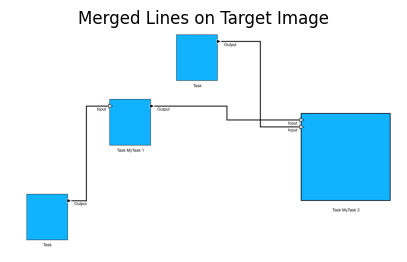

In [38]:
def connect_lines_at_containers(containers, line_segments_hor_sorted, tolerance=5):
    def find_closest_lines(container, line_segments_hor_sorted, tolerance=5):
        x, y = container
        left_lines = sorted([seg for seg in line_segments_hor_sorted if seg[1][0] < x and abs(seg[1][1] - y) <= tolerance], key=lambda seg: abs(seg[1][0] - x))[:1]
        right_lines = sorted([seg for seg in line_segments_hor_sorted if seg[0][0] > x and abs(seg[0][1] - y) <= tolerance], key=lambda seg: abs(seg[0][0] - x))[:1]

        if not left_lines or not right_lines:
            return None, None

        closest_left = left_lines[0]
        closest_right = right_lines[0]

        return closest_left, closest_right

    def merge_lines(closest_left, closest_right):
        merged_hor = [(closest_left[0][0], closest_right[1][0])]
        return merged_hor

    merged_lines = []
    for container in containers:
        closest_left, closest_right = find_closest_lines(container, line_segments_hor_sorted, tolerance)

        if closest_left is None or closest_right is None:
            continue  # Skip if there are not enough lines to merge

        merged_hor = merge_lines(closest_left, closest_right)

        line_segments_hor_sorted.remove(closest_left)
        line_segments_hor_sorted.remove(closest_right)

        new_hor_line = ((merged_hor[0][0], container[1]), (merged_hor[0][1], container[1]))

        line_segments_hor_sorted.append(new_hor_line)

        merged_lines.append(new_hor_line)

    return line_segments_hor_sorted, merged_lines

line_segments_hor_sorted, merged_lines = connect_lines_at_containers(containers, line_segments_hor_sorted, tolerance=5)

# Draw the merged lines on the target image
target_img_with_merged_lines = target_img.copy()
for line in merged_lines:
    cv2.line(target_img_with_merged_lines, line[0], line[1], (0, 0, 255), 2)

# Display the image with merged lines
plt.figure(figsize=(5, 5))
plt.imshow(cv2.cvtColor(target_img_with_merged_lines, cv2.COLOR_BGR2RGB))
plt.title('Merged Lines on Target Image')
plt.axis('off')
plt.show()

#### finding and handeling intersections - only one cross kernel is enough as it turned out
Template matching is used to locate intersections. They are processed first and then added to the rest of the line segments.

In [39]:
# finding intersections
intersections_on_target_img = target_img.copy()
cross_0 = cv2.imread('images/cross.png')

res = cv2.matchTemplate(intersections_on_target_img, cross_0, cv2.TM_CCOEFF_NORMED)

# Threshold the result
threshold = 0.9 # 0.92 or lower results in multiple matches per crossing
loc = np.where(res >= threshold)

# Move the detected crosses 6 pixels to the right and 6 pixels down so the intersections match the center of the cross
# (12 by 12 template)
loc = (loc[0] + 6, loc[1] + 6)

for pt in zip(*loc[::-1]):
    print(f"Intersection at: ({int(pt[0])}, {int(pt[1])})")


Intersection at: (1349, 478)
Intersection at: (1349, 479)


In [40]:
template_matching_result = res.copy() * 100
target_img_tmp = target_img_with_merged_lines.copy()
activate_plotly = False
# target image
if activate_plotly:
  fig = go.Figure()

  # Layer 1: 3D Plot of Heatmap
  fig.add_trace(go.Surface(
    z=template_matching_result,
    showscale=False
  ))

  # Layer 2: 2D Plot of Target Image at 10
  z_image = np.ones(target_img_tmp.shape[:2]) * 10
  fig.add_trace(go.Surface(
    z=z_image,
    showscale=False,
    # opacity=0.5,
    surfacecolor=cv2.cvtColor(target_img_tmp, cv2.COLOR_BGR2GRAY),
    colorscale='gray',
  ))

  fig.update_layout(title='Heatmap Custom Filter Vertical Edges', scene=dict(yaxis=dict(autorange='reversed')),
            height=1500, scene_aspectratio=dict(x=2, y=1, z=0.2),)
  fig.show()

#### removing double intersections

Filtered Intersection at: (1349, 478)


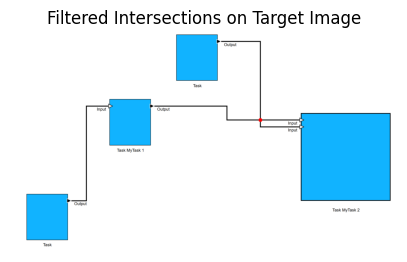

In [41]:
def remove_close_intersections(intersections, proximity=5):
    # Sort intersections by x and then by y to ensure upper left ones come first
    intersections = sorted(intersections, key=lambda pt: (pt[0], pt[1]))
    
    filtered_intersections = []
    while intersections:
        current = intersections.pop(0)
        filtered_intersections.append(current)
        
        # Remove intersections that are within the proximity range
        intersections = [pt for pt in intersections if abs(pt[0] - current[0]) > proximity or abs(pt[1] - current[1]) > proximity]
    
    return filtered_intersections

# Convert loc to a list of tuples
intersections = list(zip(*loc[::-1]))

# Remove close intersections
intersections = remove_close_intersections(intersections, proximity=5)

# Print the filtered intersections
for pt in intersections:
    print(f"Filtered Intersection at: ({int(pt[0])}, {int(pt[1])})")

# Visualize the filtered intersections on the target image
filtered_intersections_img = target_img.copy()
for pt in intersections:
    cv2.circle(filtered_intersections_img, pt, 10, (0, 0, 255), -1)
    
plt.figure(figsize=(5, 5))
plt.imshow(cv2.cvtColor(filtered_intersections_img, cv2.COLOR_BGR2RGB))
plt.title('Filtered Intersections on Target Image')
plt.axis('off')
plt.show()

### connecting intersections
At each intersection, the lines corresponding to the four nearest points are connected.

In [42]:
def find_closest_lines(crossing, line_segments_ver_sorted, line_segments_hor_sorted, tolerance=5):
    x, y = crossing
    closest_ver = sorted(line_segments_ver_sorted, key=lambda seg: min(abs(seg[0][0] - x), abs(seg[1][0] - x)) + tolerance)[:2]
    closest_hor = sorted(line_segments_hor_sorted, key=lambda seg: min(abs(seg[0][1] - y), abs(seg[1][1] - y)) + tolerance)[:2]
    return closest_ver, closest_hor

def merge_lines(closest_ver, closest_hor):
    merged_ver = (min(closest_ver[0][0][1], closest_ver[1][0][1]), max(closest_ver[0][1][1], closest_ver[1][1][1]))
    merged_hor = (min(closest_hor[0][0][0], closest_hor[1][0][0]), max(closest_hor[0][1][0], closest_hor[1][1][0]))
    return merged_ver, merged_hor

def connect_lines_at_crossings(crossings, line_segments_ver_sorted, line_segments_hor_sorted, tolerance=5):
    merged_lines = []
    for crossing in crossings:
        closest_ver, closest_hor = find_closest_lines(crossing, line_segments_ver_sorted, line_segments_hor_sorted, tolerance)
        
        if len(closest_ver) < 2 or len(closest_hor) < 2:
            continue  # Skip if there are not enough lines to merge
        
        merged_ver, merged_hor = merge_lines(closest_ver, closest_hor)
        
        for line in closest_ver:
            line_segments_ver_sorted.remove(line)
        for line in closest_hor:
            line_segments_hor_sorted.remove(line)
        
        new_ver_line = ((crossing[0], merged_ver[0]), (crossing[0], merged_ver[1]))
        new_hor_line = ((merged_hor[0], crossing[1]), (merged_hor[1], crossing[1]))
        
        line_segments_ver_sorted.append(new_ver_line)
        line_segments_hor_sorted.append(new_hor_line)
        
        merged_lines.append((new_ver_line, new_hor_line))
    
    return line_segments_ver_sorted, line_segments_hor_sorted, merged_lines

line_segments_ver_sorted, line_segments_hor_sorted, merged_lines = connect_lines_at_crossings(intersections, line_segments_ver_sorted, line_segments_hor_sorted, tolerance=5)

#### visualize the line segments

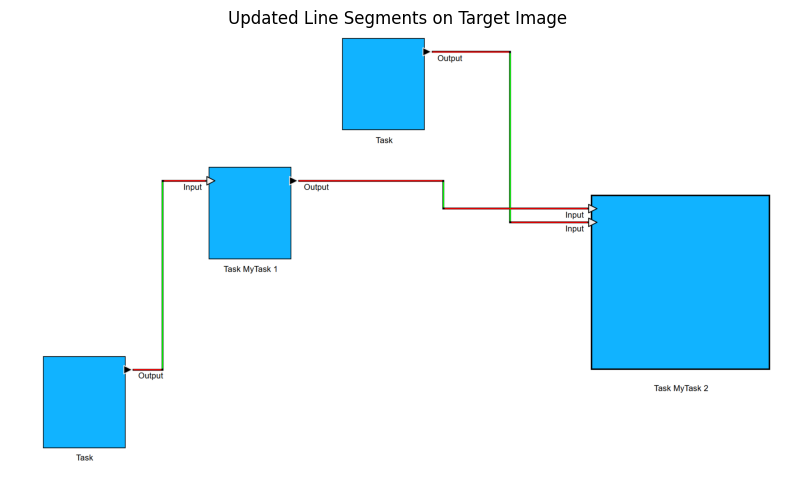

Total number of vertical line segments: 3
Total number of horizontal line segments: 6


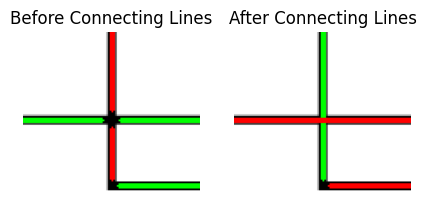

In [43]:
# Draw the updated vertical and horizontal line segments on the target image
target_img_with_merged_lines = target_img.copy()
for line in line_segments_ver_sorted:
    cv2.line(target_img_with_merged_lines, line[0], line[1], (0, 255, 0), 2)
for line in line_segments_hor_sorted:
    cv2.line(target_img_with_merged_lines, line[0], line[1], (0, 0, 255), 2)

# Display the image with updated line segments
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(target_img_with_merged_lines, cv2.COLOR_BGR2RGB))
plt.title('Updated Line Segments on Target Image')
plt.axis('off')
plt.show()
print(f"Total number of vertical line segments: {len(line_segments_ver_sorted)}")
print(f"Total number of horizontal line segments: {len(line_segments_hor_sorted)}")


# Define the zoomed area
zoom_center = intersections[-1]
zoom_size = 100

# Define the zoomed area for the image before connecting lines
x_start = max(zoom_center[0] - zoom_size // 2, 0)
x_end = min(zoom_center[0] + zoom_size // 2, target_img.shape[1])
y_start = max(zoom_center[1] - zoom_size // 2, 0)
y_end = min(zoom_center[1] + zoom_size // 2, target_img.shape[0])

# Extract the zoomed area from the image before connecting lines
zoomed_before = edges_combined_img[y_start:y_end, x_start:x_end]

# Extract the zoomed area from the image after connecting lines
zoomed_after = target_img_with_merged_lines[y_start:y_end, x_start:x_end]

# Display the zoomed images side by side
fig, ax = plt.subplots(1, 2, figsize=(5, 5))

# Plot the zoomed image before connecting lines
ax[0].imshow(cv2.cvtColor(zoomed_before, cv2.COLOR_BGR2RGB))
ax[0].set_title('Before Connecting Lines')
ax[0].axis('off')

# Plot the zoomed image after connecting lines
ax[1].imshow(cv2.cvtColor(zoomed_after, cv2.COLOR_BGR2RGB))
ax[1].set_title('After Connecting Lines')
ax[1].axis('off')

plt.show()

## convert segment chains to polylines

[[[(1169, 407), (1169, 474)], [(780, 403), (1165, 403)], [(1173, 478), (1557, 478)]], [[(411, 407), (411, 908)], [(333, 912), (407, 912)], [(416, 403), (526, 403)]], [[(1349, 60), (1349, 511)], [(1353, 515), (1557, 515)], [(1140, 56), (1345, 56)]]]


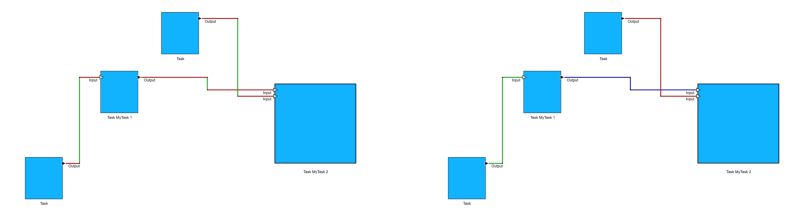

Number of found individual chains: 3


In [44]:
def distance(p1, p2):
    x1, y1, x2, y2 = p1[0], p1[1], p2[0], p2[1] 
    return np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (255, 0, 255)]

# Convert line segments to regular integers
line_segments_ver_sorted = [
    [(int(x1), int(y1)), (int(x2), int(y2))]
    for ((x1, y1), (x2, y2)) in line_segments_ver_sorted
]

line_segments_hor_sorted = [
    [(int(x1), int(y1)), (int(x2), int(y2))]
    for ((x1, y1), (x2, y2)) in line_segments_hor_sorted
]

line_segments = line_segments_ver_sorted + line_segments_hor_sorted

max_distance = 20

line_segment_chains = []
used_segments = []

for i, segment1 in enumerate(line_segments):
    if segment1 in used_segments:
        continue
    chain = [segment1]
    used_segments.append(segment1)
    
    chain_growing = True  # Flag to check if the chain is still growing
    while chain_growing:
        chain_growing = False  # Assume no new segments are added in this iteration
        for j, segment2 in enumerate(line_segments):
            if segment2 in used_segments:
                continue

            # Check if the new segment connects to any of the current chain's segments
            for chain_segment in chain:
                if (distance(chain_segment[0], segment2[0]) <= max_distance or
                    distance(chain_segment[0], segment2[1]) <= max_distance or
                    distance(chain_segment[1], segment2[0]) <= max_distance or
                    distance(chain_segment[1], segment2[1]) <= max_distance):
                    
                    chain.append(segment2)
                    used_segments.append(segment2)
                    chain_growing = True  # Keep growing the chain
                    break  # No need to check other chain segments for this one
            if chain_growing:
                break  # If we've added a segment, restart the outer loop

    line_segment_chains.append(chain)

print(line_segment_chains)

# Draw the chains on the image
target_img_with_chains = target_img.copy()
for i, chain in enumerate(line_segment_chains):
    color = colors[i % len(colors)]
    for segment in chain:
        cv2.line(target_img_with_chains, segment[0], segment[1], color, 2)

# Display the image with chains
# Display the image with the line segments drawn onto it and next to it the image with the chains
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot the image with line segments
ax[0].imshow(cv2.cvtColor(target_img_with_merged_lines, cv2.COLOR_BGR2RGB))
ax[0].axis('off')

# Plot the image with chains
ax[1].imshow(cv2.cvtColor(target_img_with_chains, cv2.COLOR_BGR2RGB))
ax[1].axis('off')

plt.show()
print(f"Number of found individual chains: {len(line_segment_chains)}")

#### finding endpoints of chains by looking for points with no other points in their proximity

In [45]:
endpoints_of_chains = []
for i, chain in enumerate(line_segment_chains):
    endpoints = []
    for segment in chain:
        for point in segment:
            if all(distance(point, other_point) > max_distance for other_segment in chain for other_point in other_segment if point != other_point):
                endpoints.append(point)
            
    print(f"Chain {i} endpoints: {endpoints}")
    endpoints_of_chains.append(endpoints)

sorted_chains = []
for i, chain in enumerate(line_segment_chains):
    if not endpoints_of_chains[i]:
        sorted_chains.append(chain)
        print(f"Chain {i} has no endpoints, skipping sorting")
        continue
    
    start_point = endpoints_of_chains[i][0]
    sorted_chain = [start_point]
    remaining_segments = chain.copy()
    
    while remaining_segments:
        last_point = sorted_chain[-1]
        next_segment = min(remaining_segments, key=lambda seg: min(distance(last_point, seg[0]), distance(last_point, seg[1])))
        remaining_segments.remove(next_segment)
        
        if distance(last_point, next_segment[0]) < distance(last_point, next_segment[1]):
            if next_segment[0] != last_point:
                sorted_chain.append(next_segment[0])
            sorted_chain.append(next_segment[1])
        else:
            if next_segment[1] != last_point:
                sorted_chain.append(next_segment[1])
            sorted_chain.append(next_segment[0])
    
    sorted_chains.append(sorted_chain)
print(sorted_chains)
print(f"Number of found endpoints: {sum(len(endpoints) for endpoints in endpoints_of_chains)}")

Chain 0 endpoints: [(780, 403), (1557, 478)]
Chain 1 endpoints: [(333, 912), (526, 403)]
Chain 2 endpoints: [(1557, 515), (1140, 56)]
[[(780, 403), (1165, 403), (1169, 407), (1169, 474), (1173, 478), (1557, 478)], [(333, 912), (407, 912), (411, 908), (411, 407), (416, 403), (526, 403)], [(1557, 515), (1353, 515), (1349, 511), (1349, 60), (1345, 56), (1140, 56)]]
Number of found endpoints: 6


#### creating and visualizing polylines

Polyline 0: (780, 403), (1165, 403), (1169, 407), (1169, 474), (1173, 478), (1557, 478)
Polyline 1: (333, 912), (407, 912), (411, 908), (411, 407), (416, 403), (526, 403)
Polyline 2: (1557, 515), (1353, 515), (1349, 511), (1349, 60), (1345, 56), (1140, 56)


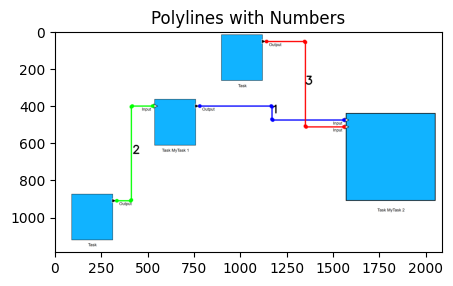

In [46]:
# Iterate through each chain and create OpenCV polylines
opencv_polylines = []
for chain in sorted_chains:
    polyline = []
    for segment in chain:
        polyline.append(segment[0])
        polyline.append(segment[1])
    opencv_polylines.append(np.array(polyline, dtype=np.int32).reshape((-1, 1, 2)))

for i, polyline in enumerate(opencv_polylines):
    formatted_points = ', '.join([f"({point[0][0]}, {point[0][1]})" for point in polyline])
    print(f"Polyline {i}: {formatted_points}")

# Filter out None values and convert to integer tuples
filtered_polylines = []
for polyline in opencv_polylines:
    filtered_polyline = [point for point in polyline if point is not None]
    filtered_polylines.append(filtered_polyline)

# Define colors for the polylines
colors = [
    (255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0), (0, 255, 255),
    (255, 0, 255), (128, 0, 0), (0, 128, 0), (0, 0, 128), (128, 128, 0),
    (0, 128, 128), (128, 0, 128), (192, 192, 192), (128, 128, 128),
    (0, 0, 0), (255, 255, 255)
]

# Draw the polylines
polyline_img = target_img.copy()
for i, polyline in enumerate(opencv_polylines):
    color = colors[i % len(colors)]
    cv2.polylines(polyline_img, [polyline], isClosed=False, color=color, thickness=6)
    for point in polyline:
        cv2.circle(polyline_img, tuple(point.squeeze()), 10, color, -1)

# Draw the lines on the target_img.copy()
target_img_with_polylines = target_img.copy()
for i, polyline in enumerate(opencv_polylines):
    color = colors[i % len(colors)]
    cv2.polylines(target_img_with_polylines, [polyline], isClosed=False, color=color, thickness=6)
    for point in polyline:
        cv2.circle(target_img_with_polylines, tuple(point.squeeze()), 10, color, -1)

# Print the number of each polyline on the image
for i, polyline in enumerate(opencv_polylines):
    # Calculate the center of the polyline for placing the text
    center_x = int(np.mean(polyline[:, 0, 0]))
    center_y = int(np.mean(polyline[:, 0, 1]))
    cv2.putText(target_img_with_polylines, str(i + 1), (center_x, center_y), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 0), 5)

# Plot the polylines with numbers
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(cv2.cvtColor(target_img_with_polylines, cv2.COLOR_BGR2RGB))
plt.title('Polylines with Numbers')
plt.show()